In [569]:
import tensorflow as tf 
from tensorflow.keras import layers,Input,Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


from tensorflow import keras
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [570]:
nifty = pd.read_csv("E:/Coding/Projects/QuantFin/main/data/NIFTY_50_20_Year_His_Data.csv")
nyse = pd.read_csv("E:/Coding/Projects/QuantFin/main/data/NYSE_20_Year_His_Data.csv")

df_nifty = pd.DataFrame(nifty)
df_nyse = pd.DataFrame(nyse)

df_nifty['Date'] = pd.to_datetime(df_nifty['Date'])
df_nyse['Date'] = pd.to_datetime(df_nyse['Date'])

df_nifty.set_index('Date', inplace=True)
df_nyse.set_index('Date', inplace=True)

common_dates = df_nifty.index.intersection(df_nyse.index)
df_nifty_common = df_nifty.loc[common_dates]
df_nyse_common = df_nyse.loc[common_dates]

df_nifty_common['return'] = df_nifty_common['Close'].pct_change()
df_nyse_common['return'] = df_nyse_common['Close'].pct_change()

# Drop NaNs from pct_change
returns_nifty = df_nifty_common['return'].dropna()
returns_nyse = df_nyse_common['return'].dropna()

# Align shapes
min_len = min(len(returns_nifty), len(returns_nyse))
returns_nifty = returns_nifty[-min_len:]
returns_nyse = returns_nyse[-min_len:]

# Build datasets
lookback = 30
x_data = []
y_data = []
for i in range(lookback, len(returns_nyse)):
    x_data.append(returns_nyse.iloc[i - lookback:i].values)
    y_data.append([returns_nifty.iloc[i]])

x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

# Train-test split
split = int(0.8 * len(x_data))
x_train, x_val = x_data[:split], x_data[split:]
y_train, y_val = y_data[:split], y_data[split:]

# x_train, x_val = x_train[:1000], x_val[:1000]
# y_train, y_val = y_train[:1000], y_val[:1000]


In [571]:
# Hyperparameters
T = 1000
beta_start = 1e-4
beta_end = 0.02
embedding_dim = 32
input_dim = lookback

In [572]:
# Noise Schedule
betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
alphas = 1.0 - betas
alpha_bars_np = np.cumprod(alphas).astype(np.float32)
alpha_bars = tf.convert_to_tensor(alpha_bars_np, dtype=tf.float32)


In [573]:
def get_timestep_embedding(timesteps, dim):
    half = dim // 2
    freqs = tf.exp(
        -tf.math.log(10000.0) * tf.range(0, half, dtype=tf.float32) / (half - 1)
    )
    angles = tf.cast(timesteps, tf.float32)[:, None] * freqs[None, :]
    emb = tf.concat([tf.sin(angles), tf.cos(angles)], axis=1)
    return emb

In [574]:
# Simple MLP Denoising Network
def get_denoise_model1():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    x = layers.Concatenate()([y_t_input, t_input, nyse_input])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1)(x)

    return Model([y_t_input, t_input, nyse_input], out)

In [575]:
# Feedforward Residual Network
def get_denoise_model2():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    nyse_proj = layers.Dense(64, activation='relu')(nyse_input)
    x = layers.Concatenate()([y_t_input, t_input, nyse_proj]) 

    # Project to residual dimension
    x_proj = layers.Dense(128)(x)  # match residual block size

    # Residual Block 1
    h = layers.Dense(128, activation='relu')(x_proj)
    h = layers.Dropout(0.1)(h)
    h = layers.Dense(128)(h)
    x = layers.Add()([x_proj, h])
    x = layers.Activation('relu')(x)

    # Residual Block 2
    h = layers.Dense(128, activation='relu')(x)
    h = layers.Dropout(0.1)(h)
    h = layers.Dense(128)(h)
    x = layers.Add()([x, h])
    x = layers.Activation('relu')(x)
    
    out = layers.Dense(1)(x)

    return Model([y_t_input,t_input,nyse_input],out)

In [576]:
# Residual LSTM Denoising Model
def get_denoise_model3():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    t_emb = layers.Dense(32, activation='relu')(t_input)
    x = layers.Concatenate()([t_emb, nyse_input])
    x = layers.Reshape((1, 62))(x)

    lstm_out = layers.LSTM(64, return_sequences=True)(x)
    skip = lstm_out  # Save for residual

    lstm_out = layers.LSTM(64, return_sequences=False)(lstm_out)
    x = layers.Concatenate()([lstm_out, y_t_input])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1)(x)

    return Model(inputs=[y_t_input, t_input, nyse_input], outputs=x)



In [577]:
# Self-Attention-Based Denoising Model
def get_denoise_model4():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    x = layers.Reshape((input_dim, 1))(nyse_input)
    attention = layers.MultiHeadAttention(num_heads=2, key_dim=16)
    x = attention(x, x)
    x = layers.Flatten()(x)

    x = layers.Concatenate()([x, t_input, y_t_input])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1)(x)

    return Model([y_t_input, t_input, nyse_input], x)


In [ ]:
# # Transformer Encoder Block
# def get_denoise_model5():
#     y_t_input = Input(shape=(1,))
#     t_input = Input(shape=(embedding_dim,))
#     nyse_input = Input(shape=(input_dim,))

#     x = layers.Reshape((input_dim, 1))(nyse_input)
#     x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
#     x = layers.LayerNormalization()(x)
#     x = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
#     x = layers.GlobalAveragePooling1D()(x)

#     x = layers.Concatenate()([x, y_t_input, t_input])
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dense(1)(x)

#     return Model([y_t_input, t_input, nyse_input], x)

# from tensorflow.keras import layers, Input, Model
# import tensorflow as tf

# def get_denoise_model5():
#     y_t_input = Input(shape=(1,))
#     t_input = Input(shape=(embedding_dim,))
#     nyse_input = Input(shape=(input_dim,))

#     # Step 1: Reshape NYSE input for sequence processing
#     nyse_reshaped = layers.Reshape((input_dim, 1))(nyse_input)  # (None, 30, 1)

#     # Step 2: Generate sinusoidal position embeddings (frozen, not learnable)
#     position = tf.range(start=0, limit=input_dim, delta=1)  # (30,)
    
#     # pos_emb = get_timestep_embedding(position, dim=8)  # (30, 8)
    
#     pos_emb_layer = layers.Embedding(input_dim=input_dim, output_dim=8)
#     pos_emb_tensor = pos_emb_layer(position)

#     pos_emb = tf.expand_dims(pos_emb, axis=0)  # (1, 30, 8)
#     pos_emb_layer = tf.constant(pos_emb.numpy())  # convert to constant tensor

#     # Broadcast to batch size using Lambda (ensures symbolic compatibility)
#     def repeat_pos_emb(x):
#         batch_size = tf.shape(x)[0]
#         return tf.tile(pos_emb_layer, [batch_size, 1, 1])

#     pos_emb_tensor = layers.Lambda(repeat_pos_emb)(nyse_reshaped)

#     # Step 3: Concatenate NYSE input with positional embeddings
#     x = layers.Concatenate(axis=-1)([nyse_reshaped, pos_emb_tensor])  # (None, 30, 9)

#     # Step 4: Conv + MHA + Pool
#     x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
#     x = layers.LayerNormalization()(x)
#     x = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
#     x = layers.GlobalAveragePooling1D()(x)

#     # Step 5: Combine with y_t and t embeddings
#     x = layers.Concatenate()([x, y_t_input, t_input])
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dense(1)(x)

#     return Model([y_t_input, t_input, nyse_input], x)



# # # Currently Best 
# def get_denoise_model5():
#     y_t_input = Input(shape=(1,))
#     t_input = Input(shape=(embedding_dim,))
#     nyse_input = Input(shape=(input_dim,))

#     # Step 1: Reshape NYSE input for sequence processing
#     nyse_reshaped = layers.Reshape((input_dim, 1))(nyse_input)  # (None, 30, 1)

#     # Step 2: Trainable positional embeddings
#     pos_ids = tf.range(start=0, limit=input_dim, delta=1)  # (30,)
#     pos_emb_layer = layers.Embedding(input_dim=input_dim, output_dim=8)  # trainable
#     pos_emb_tensor = pos_emb_layer(pos_ids)  # (30, 8)
#     pos_emb_tensor = tf.expand_dims(pos_emb_tensor, axis=0)  # (1, 30, 8)

#     # Broadcast to batch size using Lambda
#     def repeat_pos_emb(x):
#         batch_size = tf.shape(x)[0]
#         return tf.tile(pos_emb_tensor, [batch_size, 1, 1])

#     pos_emb_broadcasted = layers.Lambda(repeat_pos_emb)(nyse_reshaped)

#     # Step 3: Concatenate NYSE input with positional embeddings
#     x = layers.Concatenate(axis=-1)([nyse_reshaped, pos_emb_broadcasted])  # (None, 30, 9)

#     # Step 4: Conv + MHA + Dropout
#     x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
#     x = layers.LayerNormalization()(x)
#     x = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
#     x = layers.Dropout(0.1)(x)  # Dropout after attention
#     x = layers.GlobalAveragePooling1D()(x)

#     # Step 5: Combine with y_t and t embeddings
#     x = layers.Concatenate()([x, y_t_input, t_input])
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dropout(0.1)(x)  # Dropout after dense
#     x = layers.Dense(1)(x)

#     return Model([y_t_input, t_input, nyse_input], x)

from tensorflow.keras.regularizers import l2

def get_denoise_model5():
    y_t_input = Input(shape=(1,))
    t_input = Input(shape=(embedding_dim,))
    nyse_input = Input(shape=(input_dim,))

    # Step 1: Reshape NYSE input for sequence processing
    nyse_reshaped = layers.Reshape((input_dim, 1))(nyse_input)  # (None, 30, 1)

    # Step 2: Frozen positional embeddings
    position = tf.range(start=0, limit=input_dim, delta=1)
    pos_emb = get_timestep_embedding(position, dim=8)  # (30, 8)
    pos_emb = tf.expand_dims(pos_emb, axis=0)  # (1, 30, 8)
    pos_emb_layer = tf.constant(pos_emb.numpy())

    def repeat_pos_emb(x):
        batch_size = tf.shape(x)[0]
        return tf.tile(pos_emb_layer, [batch_size, 1, 1])

    pos_emb_tensor = layers.Lambda(repeat_pos_emb)(nyse_reshaped)

    # Step 3: Concatenate NYSE input with positional embeddings
    x = layers.Concatenate(axis=-1)([nyse_reshaped, pos_emb_tensor])  # (None, 30, 9)

    # Step 4: Conv1D + LayerNorm
    x = layers.Conv1D(
        filters=128,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(1e-4)
    )(x)
    x = layers.LayerNormalization()(x)

    # Step 5: Transformer Self-Attention with Residual
    residual = x  # Save for residual connection
    attention_out = layers.MultiHeadAttention(num_heads=4, key_dim=16, dropout=0.1)(x, x)
    x = layers.Add()([residual, attention_out])  # Residual connection
    x = layers.LayerNormalization()(x)

    # Optional Dropout (after attention+residual)
    x = layers.Dropout(0.1)(x)

    # Step 6: Global pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Step 7: Combine with y_t and t embeddings
    x = layers.Concatenate()([x, y_t_input, t_input])
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = layers.Dense(1, kernel_regularizer=l2(1e-4))(x)

    return Model([y_t_input, t_input, nyse_input], x)




In [579]:
# Forward Pass
def q_sample(y_0,t,noise):
    a_bar = tf.gather(alpha_bars,t)
    a_bar = tf.reshape(a_bar,(-1,1))
    return tf.sqrt(a_bar)*y_0+tf.sqrt(1.-a_bar)*noise

In [580]:
#  Training Step
@tf.function
def train_step(model,optimizer,x_batch,y_batch):
    batch_size = tf.shape(x_batch)[0]
    t = tf.random.uniform((batch_size,),minval=0,maxval=T,dtype=tf.int32)
    # t_emb = get_timestep_embedding(t.numpy(),embedding_dim)
    t_emb = get_timestep_embedding(t,embedding_dim)

    noise = tf.random.normal(shape=tf.shape(y_batch))
    y_t = q_sample(y_batch,t,noise)

    with tf.GradientTape() as tape:
        pred_noise = model([y_t,t_emb,x_batch],training=True)
        loss = tf.reduce_mean(tf.square(pred_noise-noise))
    
    grads = tape.gradient(loss,model.trainable_weights)
    optimizer.apply_gradients(zip(grads,model.trainable_weights))
    
    return loss

In [581]:
#  DDIM Sampling
def ddim_sample(model, x_cond, embedding_dim, alpha_bars, T, eta=0.0):
    batch_size = tf.shape(x_cond)[0]
    y_t = tf.random.normal((batch_size, 1))

    for i in reversed(range(1, T)):
        batch_size = tf.shape(x_cond)[0]
        t = tf.fill([batch_size], i)  # shape (234,)
        t_emb = get_timestep_embedding(t, embedding_dim)
        # t_emb = tf.repeat(t_emb, repeats=batch_size, axis=0)

        pred_noise = model([y_t, t_emb, x_cond], training=False)

        a_bar = tf.gather(alpha_bars, t)
        a_bar_prev = tf.gather(alpha_bars, t-1)

        a_bar = tf.reshape(a_bar, (-1, 1))
        a_bar_prev = tf.reshape(a_bar_prev, (-1, 1))

        y_0 = (y_t - tf.sqrt(1. - a_bar) * pred_noise) / tf.sqrt(a_bar)
        y_t = tf.sqrt(a_bar_prev) * y_0 + tf.sqrt(1. - a_bar_prev) * pred_noise

    return y_0

In [582]:
#  Training 

# model1 = get_denoise_model1()
# model2 = get_denoise_model2()
# model3 = get_denoise_model3()
# model4 = get_denoise_model4()
model5 = get_denoise_model5()
# optimizer1 = Adam(1e-3)
# optimizer2 = Adam(1e-3)
# optimizer3 = Adam(1e-3)
# optimizer4 = Adam(1e-3)

from tensorflow.keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.98,
    staircase=True
)
optimizer5 = Adam(learning_rate=lr_schedule)

nyse_scaler = StandardScaler()
nse_scaler = StandardScaler()

x_train = nyse_scaler.fit_transform(x_train)
x_val = nyse_scaler.transform(x_val)

y_train = nse_scaler.fit_transform(y_train)
y_val = nse_scaler.transform(y_val)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(64)
x_val_batch = tf.convert_to_tensor(x_val, dtype=tf.float32)

num_epochs = 200
# print("Training Model1")
# for epoch in range(num_epochs):
#     for x_batch, y_batch in train_dataset:
#         loss = train_step(model1, optimizer1, x_batch, y_batch)
#     print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

In [583]:
# # Evaluation 
# preds = ddim_sample(model1, x_val_batch)
# preds = preds.numpy()
# preds = nse_scaler.inverse_transform(preds)

# true_y = nse_scaler.inverse_transform(y_val)

# mse = mean_squared_error(true_y, preds)
# mae = mean_absolute_error(true_y, preds)
# print(f"Model 1 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# # Drift Adjustment
# nse_trend = np.mean(true_y)  
# preds_with_drift = preds + nse_trend

# # Recalculate Metrics 
# mse_drift = mean_squared_error(true_y, preds_with_drift)
# mae_drift = mean_absolute_error(true_y, preds_with_drift)

# print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# # Directional Accuracy with Drift 
# direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
# print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# # Plot 
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 4))
# plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
# plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
# plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
# plt.legend()
# plt.show()

In [584]:
# print("Training Model2")
# for epoch in range(num_epochs):
#     for x_batch, y_batch in train_dataset:
#         loss = train_step(model2, optimizer2, x_batch, y_batch)
#     print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

In [585]:
# preds = ddim_sample(model2, x_val_batch)
# preds = preds.numpy()
# preds = nse_scaler.inverse_transform(preds)

# true_y = nse_scaler.inverse_transform(y_val)

# mse = mean_squared_error(true_y, preds)
# mae = mean_absolute_error(true_y, preds)
# print(f"Model 2 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# # Drift Adjustment
# nse_trend = np.mean(true_y)  
# preds_with_drift = preds + nse_trend

# # Recalculate Metrics 
# mse_drift = mean_squared_error(true_y, preds_with_drift)
# mae_drift = mean_absolute_error(true_y, preds_with_drift)

# print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# # Directional Accuracy with Drift 
# direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
# print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# # Plot 
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 4))
# plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
# plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
# plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
# plt.legend()
# plt.show()


In [586]:
# print("Training Model3")
# for epoch in range(num_epochs):
#     for x_batch, y_batch in train_dataset:
#         loss = train_step(model3, optimizer3, x_batch, y_batch)
#     print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

In [587]:
# preds = ddim_sample(model3, x_val_batch,embedding_dim,alpha_bars,T)
# preds = preds.numpy()
# preds = nse_scaler.inverse_transform(preds)

# true_y = nse_scaler.inverse_transform(y_val)

# mse = mean_squared_error(true_y, preds)
# mae = mean_absolute_error(true_y, preds)
# print(f"Model 3 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# # Drift Adjustment
# nse_trend = np.mean(true_y)  
# preds_with_drift = preds + nse_trend

# # Recalculate Metrics 
# mse_drift = mean_squared_error(true_y, preds_with_drift)
# mae_drift = mean_absolute_error(true_y, preds_with_drift)

# print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# # Directional Accuracy with Drift 
# direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
# print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# # Plot 
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 4))
# plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
# plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
# plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
# plt.legend()
# plt.show()


In [588]:
# print("Training Model4")
# for epoch in range(num_epochs):
#     for x_batch, y_batch in train_dataset:
#         loss = train_step(model4, optimizer4, x_batch, y_batch)
#     print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

In [589]:
# preds = ddim_sample(model4, x_val_batch)
# preds = preds.numpy()
# preds = nse_scaler.inverse_transform(preds)

# true_y = nse_scaler.inverse_transform(y_val)

# mse = mean_squared_error(true_y, preds)
# mae = mean_absolute_error(true_y, preds)
# print(f"Model 4 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# # Drift Adjustment
# nse_trend = np.mean(true_y)  
# preds_with_drift = preds + nse_trend

# # Recalculate Metrics 
# mse_drift = mean_squared_error(true_y, preds_with_drift)
# mae_drift = mean_absolute_error(true_y, preds_with_drift)

# print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# # Directional Accuracy with Drift 
# direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
# print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# # Plot 
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 4))
# plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
# plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
# plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
# plt.legend()
# plt.show()


In [590]:
print("Training Model5")
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataset:
        loss = train_step(model5, optimizer5, x_batch, y_batch)
    print(f"Epoch {epoch+1}: Loss = {loss.numpy():.4f}")

Training Model5
Epoch 1: Loss = 0.3669
Epoch 2: Loss = 0.3399
Epoch 3: Loss = 0.5149
Epoch 4: Loss = 0.1402
Epoch 5: Loss = 0.2288
Epoch 6: Loss = 0.4941
Epoch 7: Loss = 0.1949
Epoch 8: Loss = 0.1618
Epoch 9: Loss = 0.4364
Epoch 10: Loss = 0.3003
Epoch 11: Loss = 0.2138
Epoch 12: Loss = 0.1368
Epoch 13: Loss = 0.2934
Epoch 14: Loss = 0.3578
Epoch 15: Loss = 0.1423
Epoch 16: Loss = 0.2786
Epoch 17: Loss = 0.3274
Epoch 18: Loss = 0.1241
Epoch 19: Loss = 0.3218
Epoch 20: Loss = 0.2989
Epoch 21: Loss = 0.1855
Epoch 22: Loss = 0.3579
Epoch 23: Loss = 0.2930
Epoch 24: Loss = 0.1413
Epoch 25: Loss = 0.1542
Epoch 26: Loss = 0.0874
Epoch 27: Loss = 0.2512
Epoch 28: Loss = 0.2351
Epoch 29: Loss = 0.1920
Epoch 30: Loss = 0.3614
Epoch 31: Loss = 0.2360
Epoch 32: Loss = 0.3524
Epoch 33: Loss = 0.1342
Epoch 34: Loss = 0.1326
Epoch 35: Loss = 0.1704
Epoch 36: Loss = 0.1804
Epoch 37: Loss = 0.1523
Epoch 38: Loss = 0.1193
Epoch 39: Loss = 0.3738
Epoch 40: Loss = 0.1614
Epoch 41: Loss = 0.1427
Epoch 42:

Model 5 -> MSE: 0.000445, MAE: 0.010444
Drift-Adjusted MSE: 0.000443, MAE: 0.010424
Drift-Adjusted Directional Accuracy: 55.93%


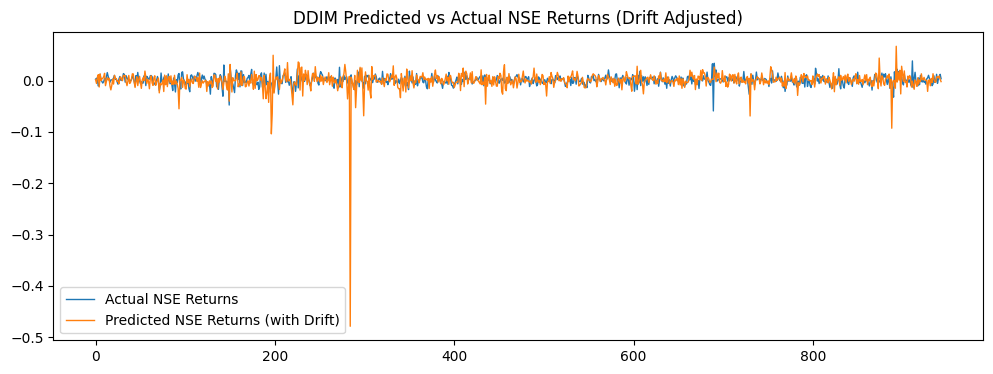

In [591]:
preds = ddim_sample(model5, x_val_batch,embedding_dim,alpha_bars,T)
preds = preds.numpy()
preds = nse_scaler.inverse_transform(preds)

true_y = nse_scaler.inverse_transform(y_val)

mse = mean_squared_error(true_y, preds)
mae = mean_absolute_error(true_y, preds)
print(f"Model 5 -> MSE: {mse:.6f}, MAE: {mae:.6f}")

# Drift Adjustment
nse_trend = np.mean(true_y)  
preds_with_drift = preds + nse_trend

# Recalculate Metrics 
mse_drift = mean_squared_error(true_y, preds_with_drift)
mae_drift = mean_absolute_error(true_y, preds_with_drift)

print(f"Drift-Adjusted MSE: {mse_drift:.6f}, MAE: {mae_drift:.6f}")

# Directional Accuracy with Drift 
direction_accuracy_drift = np.mean(np.sign(true_y) == np.sign(preds_with_drift)) * 100
print(f"Drift-Adjusted Directional Accuracy: {direction_accuracy_drift:.2f}%")

# Plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(true_y, label='Actual NSE Returns', linewidth=1)
plt.plot(preds_with_drift, label='Predicted NSE Returns (with Drift)', linewidth=1)
plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
plt.legend()
plt.show()


In [592]:
# def predict_one_day(model, x_input, nse_scaler, embedding_dim, alpha_bars, T, y_val=None): 
#     x_tensor = tf.convert_to_tensor(x_input)

#     # DDIM Sample
#     pred = ddim_sample(model, x_tensor, embedding_dim,alpha_bars, T)
#     pred_unscaled = nse_scaler.inverse_transform(pred.numpy())

#     # Drift-adjusted prediction (if y_val provided)
#     if y_val is not None:
#         nse_trend = np.mean(nse_scaler.inverse_transform(y_val))
#     else:
#         nse_trend = 0.0

#     pred_drifted = pred_unscaled + nse_trend
#     direction = int(np.sign(pred_drifted[0, 0]))

#     return pred_unscaled[0, 0], pred_drifted[0, 0], direction

# x_val_sample = x_val[-1].reshape(1, -1).astype(np.float32)  # shape (30,)
# pred_unscaled, pred_drifted, direction = predict_one_day(model5, x_val_sample, nse_scaler, embedding_dim, alpha_bars, T, y_val=y_val)

# print(f"Pred_unscaled = {pred_unscaled}\nPred_drifted = {pred_drifted}\nDirection = {direction}")


In [593]:
def predict_next_day_from_validation(model, x_val, y_val, nse_scaler, embedding_dim, alpha_bars, T):
    """
    Predicts the next NSE return using the last NYSE conditioning input from validation set.
    
    Args:
        model: trained denoising model
        x_val: validation NYSE inputs (scaled), shape (N, 30)
        y_val: validation NSE returns (scaled), shape (N, 1)
        nse_scaler: fitted scaler for NSE
        embedding_dim: timestep embedding dim
        alpha_bars: alpha_bar schedule for DDIM
        T: number of DDIM steps

    Returns:
        pred_unscaled: predicted NSE return (raw)
        pred_drifted: predicted NSE return (drift adjusted)
        direction: 1 (up) or -1 (down)
    """
    # Get the most recent conditioning window
    x_input = x_val[-1].reshape(1, -1).astype(np.float32)

    # DDIM Sampling
    x_tensor = tf.convert_to_tensor(x_input)
    pred = ddim_sample(model, x_tensor, embedding_dim, alpha_bars, T)
    pred_unscaled = nse_scaler.inverse_transform(pred.numpy())

    # Drift Adjustment using overall y_val (validation NSE)
    nse_trend = np.mean(nse_scaler.inverse_transform(y_val))
    pred_drifted = pred_unscaled + nse_trend

    # Direction: +1 = Up, -1 = Down, 0 = Flat
    direction = int(np.sign(pred_drifted[0, 0]))

    print("=== Prediction for Next Day ===")
    print(f"NSE Return (Raw)           : {pred_unscaled[0, 0]:.6f}")
    print(f"NSE Return (Drift Adjusted): {pred_drifted[0, 0]:.6f}")
    print(f"Predicted Direction        : {'Up' if direction == 1 else 'Down' if direction == -1 else 'Flat'}")

    return pred_unscaled[0, 0], pred_drifted[0, 0], direction

pred_unscaled, pred_drifted, direction = predict_next_day_from_validation(
    model5, x_val, y_val, nse_scaler, embedding_dim, alpha_bars, T
)
# pred_unscaled, pred_drifted, direction = predict_next_day_from_validation(
#     model3, x_val, y_val, nse_scaler, embedding_dim, alpha_bars, T
# )

=== Prediction for Next Day ===
NSE Return (Raw)           : 0.001842
NSE Return (Drift Adjusted): 0.002394
Predicted Direction        : Up


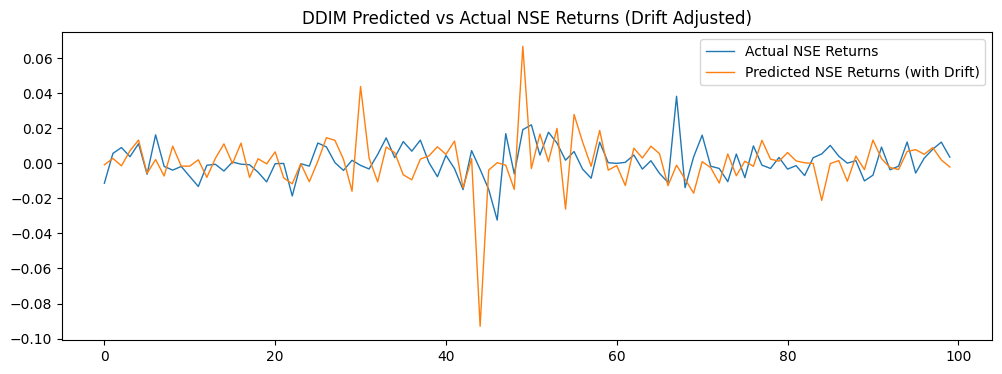

In [594]:
plt.figure(figsize=(12, 4))
plt.plot(true_y[-100:], label='Actual NSE Returns', linewidth=1)
plt.plot(preds_with_drift[-100:], label='Predicted NSE Returns (with Drift)', linewidth=1)
plt.title("DDIM Predicted vs Actual NSE Returns (Drift Adjusted)")
plt.legend()
plt.show()